In [1]:
import logging
import warnings
from datetime import datetime, timedelta
from typing import List, Dict, Any

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

warnings.filterwarnings("ignore")

logging.basicConfig()
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

# Идея
Будем использовать подход на основе модели эластичности без персонализации (без учета пользователей):
- базовый спрос считаем как среднее количество товара за 56 дней
- эластичность считаем по кривой эластичности: по истории рисуем кривую эластичности (groupby по (sku_id, price), агрегация mean(is_bought))
- для нормализации цены используем базовую цену
- в качестве оптимизации используем метод множителей Лагранжа

# Данные

In [2]:
history_df = pd.read_csv("./fp/payments_history.csv")
history_df.head()

,ds,sku_id,user_id,price
0,20230901,0,5,3362.69
1,20230901,0,6,3655.10
2,20230901,0,8,3947.51
3,20230901,0,9,3655.10
4,20230901,0,10,3362.69


In [3]:
sku_df = pd.read_csv("./fp/skus.csv")
sku_df.head()

,sku_id,base_price,commission
0,0,3655.10,0.3
1,1,4977.18,0.1
2,2,6663.22,0.3
3,3,6116.77,0.1
4,4,5238.07,0.3


In [4]:
start_dt = datetime(2024, 1, 1)
end_dt = datetime(2024, 1, 14)
dt_list = [
    start_dt + timedelta(days=days) for days in range((end_dt - start_dt).days + 1)
]
ds_list = [int(dt.strftime("%Y%m%d")) for dt in dt_list]
ds_df = pd.DataFrame({"ds": ds_list})

# Базовый спрос

In [5]:
def calc_rolling_window(
    df: pd.DataFrame,
    window: int,
    col: str,
    lvl: str,
    shift: int,
) -> pd.DataFrame:
    df = df.sort_values(["ds", lvl])
    df["ts"] = pd.to_datetime(df["ds"].astype(str))
    df["col"] = df[col]
    rolling_df = df.set_index("ts")
    rolling_df = (
        rolling_df.groupby([lvl], group_keys=True)["col"]
        # используем shift, так как потом нам нужно предсказывать на N дней вперед:
        # для однородности датасета используем сдвиг на кол-во дат в предсказании
        .apply(
            lambda x: x.asfreq("1D")
            .rolling(window=window, closed="left", min_periods=0)
            .mean()
            .shift(shift)
        )
        .reset_index()
        .rename(columns={"col": f"rolling_{col}_w_{window}"})
    )
    df = df.merge(rolling_df, how="left", on=[lvl, "ts"])
    df = df.drop(columns=["ts", "col"])
    return df

In [6]:
sku_sales_df = history_df.copy(deep=True)
sku_sales_df = (
    sku_sales_df.groupby(["ds", "sku_id"]).agg({"price": "count"}).reset_index()
)
sku_sales_df = sku_sales_df.rename(columns={"price": "quantity"})
sku_sales_df.head()

,ds,sku_id,quantity
0,20230901,0,51
1,20230901,1,48
2,20230901,2,52
3,20230901,3,61
4,20230901,4,51


In [7]:
base_demand_df = sku_sales_df.copy(deep=True)[["sku_id"]].drop_duplicates()

base_demand_df = base_demand_df.merge(ds_df, how="cross")

base_demand_df["quantity"] = None
cols = base_demand_df.columns.tolist()
base_demand_df = pd.concat(
    [
        sku_sales_df.copy(deep=True).sort_values(by=["sku_id", "ds"])[cols],
        base_demand_df[cols],
    ]
)
base_demand_df = calc_rolling_window(
    df=base_demand_df,
    window=56,
    col="quantity",
    lvl="sku_id",
    shift=14,
)
base_demand_df = base_demand_df[base_demand_df["ds"].isin(ds_list)]
base_demand_df = base_demand_df[["sku_id", "ds", "rolling_quantity_w_56"]].round()
base_demand_df = base_demand_df.rename(
    columns={
        "rolling_quantity_w_56": "quantity",
    }
)
base_demand_df.head()

,sku_id,ds,quantity
122000,0,20240101,51.0
122001,1,20240101,50.0
122002,2,20240101,50.0
122003,3,20240101,51.0
122004,4,20240101,50.0


# Эластичность

In [8]:
def calculate_elasticity(df: pd.DataFrame, column: str, lvl: List[str]) -> pd.DataFrame:
    df[f"prev_{column}"] = df.groupby(lvl)[column].shift(1)
    df["prev_price"] = df.groupby(lvl)["price"].shift(1)
    df = df[df["prev_price"] - df["price"] != 0]
    df[f"elasticity_{column}_{'_'.join(lvl)}"] = (
        (df[column] - df[f"prev_{column}"]) / (df["price"] - df["prev_price"])
    ) * ((df["price"] + df["prev_price"]) / (df[column] + df[f"prev_{column}"]))
    df = (
        df.groupby(lvl)
        .agg({f"elasticity_{column}_{'_'.join(lvl)}": "mean"})
        .reset_index()
    )
    df[f"elasticity_{column}_{'_'.join(lvl)}"] = (
        df[f"elasticity_{column}_{'_'.join(lvl)}"].clip(upper=-10.0, lower=0).round(2)
    )
    return df

In [9]:
sku_curve_df = history_df.copy(deep=True)
sku_curve_df = (
    sku_curve_df.groupby(["sku_id", "price"]).agg({"ds": "count"}).reset_index()
)
sku_curve_df = sku_curve_df.rename(columns={"ds": "quantity"})
sku_curve_df.head()

,sku_id,price,quantity
0,0,3289.59,801
1,0,3362.69,791
2,0,3435.79,745
3,0,3508.90,699
4,0,3582.00,586


In [10]:
sku_elasticity_df = calculate_elasticity(
    df=sku_curve_df.sort_values(["sku_id", "price"]),
    column="quantity",
    lvl=["sku_id"],
)
sku_elasticity_df.sort_values("sku_id").head(10)

,sku_id,elasticity_quantity_sku_id
0,0,-5.02
1,1,-6.47
2,2,-10.00
3,3,-10.00
4,4,-5.26
5,5,-10.00
6,6,-0.97
7,7,-3.69
8,8,-6.17
9,9,-8.69


# Спрос

In [11]:
pred_df = sku_df.copy(deep=True)
pred_df = pred_df.merge(ds_df, how="cross")

# Мержим базовый спрос
pred_df = pred_df.merge(base_demand_df, on=["sku_id", "ds"], how="left")

# Мержим эластичность
pred_df = pred_df.merge(sku_elasticity_df, on=["sku_id"], how="left")

# Предсказываем спрос для разных цен
markups_pred_df = pd.DataFrame(
    {"markup": np.arange(-0.1, 0.11, 0.02).round(2).tolist()}
)
pred_df = pred_df.join(markups_pred_df, how="cross")
pred_df["price"] = pred_df["base_price"] + pred_df["base_price"] * pred_df["markup"]
pred_df["price_norm"] = pred_df["price"] / pred_df["base_price"]
pred_df["quantity"] = pred_df["quantity"] * pow(
    pred_df["price_norm"], pred_df["elasticity_quantity_sku_id"]
)
pred_df["revenue"] = pred_df["quantity"] * pred_df["price"]
pred_df["margin"] = (
    pred_df["revenue"] * pred_df["commission"] + pred_df["revenue"] * pred_df["markup"]
)

print(pred_df.shape)
pred_df.head(12)

(154000, 11)


,sku_id,base_price,commission,ds,quantity,elasticity_quantity_sku_id,markup,price,price_norm,revenue,margin
0,0,3655.1,0.3,20240101,86.551137,-5.02,-0.10,3289.590,0.90,284717.755583,56943.551117
1,0,3655.1,0.3,20240101,77.509562,-5.02,-0.08,3362.692,0.92,260640.784114,57340.972505
2,0,3655.1,0.3,20240101,69.577425,-5.02,-0.06,3435.794,0.94,239053.698899,57372.887736
3,0,3655.1,0.3,20240101,62.599172,-5.02,-0.04,3508.896,0.96,219653.982924,57110.035560
4,0,3655.1,0.3,20240101,56.443674,-5.02,-0.02,3581.998,0.98,202181.127970,56610.715832
5,0,3655.1,0.3,20240101,51.000000,-5.02,0.00,3655.100,1.00,186410.100000,55923.030000
6,0,3655.1,0.3,20240101,46.173980,-5.02,0.02,3728.202,1.02,172145.925915,55086.696293
7,0,3655.1,0.3,20240101,41.885414,-5.02,0.04,3801.304,1.04,159219.191928,54134.525256
8,0,3655.1,0.3,20240101,38.065780,-5.02,0.06,3874.406,1.06,147482.286151,53093.623014
9,0,3655.1,0.3,20240101,34.656358,-5.02,0.08,3947.508,1.08,136806.251188,51986.375452


# Оптимизация

In [12]:
def log_uplifts(
    constraints: Dict[str, float],
    maximized_column: str,
    optimal_statistics: Dict[str, float],
) -> None:
    """
    Функция для логирования значений метрик и их аплифтов (улучшений).

    :param constraints: Словарь ограничений для метрик.
    :param maximized_column: Название столбца, который подлежит максимизации.
    :param optimal_statistics: Словарь с оптимальными статистическими данными.
    """
    # Логируем значение метрики, которую мы максимизируем
    logger.info(
        f"Metric: {maximized_column}",
        extra={"value": optimal_statistics.get(maximized_column)},
    )

    # Проходим по всем метрикам и их ограничениям
    for metric, constraint in constraints.items():
        optimal_value = optimal_statistics.get(metric)
        if optimal_value is None:
            raise ValueError(f"`{metric}` has not been counted")
        # Логируем информацию по каждой метрике, включая аплифты
        log_dict = {
            "constraint value": round(constraint, 3),
            "optimal value": round(optimal_value, 3),
            "uplift (abs)": round(optimal_value - constraint, 3),
            "uplift (pct)": round(optimal_value * 100 / constraint - 100, 3),
        }
        logger.info(f"Metric: {metric}")
        for key, value in log_dict.items():
            logger.info(f"{key}= {value}")


def apply_constraints(
    df: pd.DataFrame,
    constraints: Dict[str, float],
) -> pd.DataFrame:
    """
    Фильтруем датасет по заданным ограничениям.

    :param df: DataFrame с данными для фильтрации.
    :param constraints: Словарь ограничений для каждой метрики.
    :return: Отфильтрованный DataFrame.
    """
    # Применяем ограничения к датафрейму, фильтруя строки
    for metric, constraint in constraints.items():
        df = df[df[metric] >= constraint]
    return df


def calculate_cum_lambda_metrics(
    df: pd.DataFrame,
    agg_columns: List[str],
) -> pd.DataFrame:
    """
    Считаем агрегированные значения метрик для каждой комбинации лямбда-значений.

    :param df: DataFrame с данными.
    :param agg_columns: Список столбцов для агрегации.
    :param maximized_column: Столбец, который максимизируется.
    :return: Агрегированный DataFrame.
    """
    # Группируем данные по комбинации лямбда-значений и агрегируем указанные столбцы
    df = df.groupby("lambda_combination").agg({column: "sum" for column in agg_columns})
    df = df.reset_index()
    return df


def choose_optimal_values(
    metric_lambda_map: Dict[str, float],
    df: pd.DataFrame,
    levels: List[str],
    price_column: str,
    maximized_column: str,
) -> pd.DataFrame:
    """
    Находим оптимальные цены / наценки для каждого уровня для lambda_value
    """
    # Считаем лагранжианы при lambda_value
    df["lagrangian"] = df[maximized_column]
    lambda_combination_name = ""
    for metric, metric_lambda in metric_lambda_map.items():
        df["lagrangian"] += df[metric] * metric_lambda
        lambda_combination_name += f"{metric}={metric_lambda}_"
    # Находим максимальный лагранжиан для каждого уровня
    optimal_df = df.groupby(levels).agg({"lagrangian": "max"})
    df = df.merge(optimal_df, on=levels + ["lagrangian"], how="inner")
    # Добавляем колонку с lambda_value для запоминания
    df["lambda_combination"] = lambda_combination_name.strip("_")
    # Удаляем дубликаты (например, оставляем минимальные цены / наценки из оптимальных),
    # так как возможны одни и те же значения метрик для разных цен / наценок
    # => одинаковые лагранжианы, а нам нужно выбрать одно значение для каждого уровня
    df = df.sort_values(price_column)
    df = df.drop_duplicates(subset=levels)
    return df


def get_metric_lambda_maps(lambda_config: Dict[str, Any]) -> List[Dict[str, float]]:
    # Получаем список значений для каждого ключа
    lambda_lists = list(lambda_config.values())
    # Используем meshgrid для генерации всех комбинаций параметров
    lambda_mesh = np.meshgrid(*lambda_lists)
    # Преобразование в массив и решейпинг
    lambda_vars = np.stack(lambda_mesh, axis=-1).reshape(-1, len(lambda_config))
    # Создаем список словарей
    metric_lambda_maps = [
        dict(zip(lambda_config.keys(), combination)) for combination in lambda_vars
    ]
    return metric_lambda_maps


def calculate_lagrangians(
    df: pd.DataFrame,
    lambda_config: Dict[str, Any],
    levels: List[str],
    price_column: str,
    maximized_column: str,
) -> pd.DataFrame:
    """
    Для каждого значения lambda находим оптимальные цены / наценки для каждого уровня
    """
    lambda_dfs = []
    metric_lambda_maps = get_metric_lambda_maps(lambda_config=lambda_config)
    logger.info(
        f"Start calculating lagrangians, {len(metric_lambda_maps)} lambda combinations"
    )
    for metric_lambda_map in metric_lambda_maps:
        lambda_df = choose_optimal_values(
            metric_lambda_map=metric_lambda_map,
            df=df,
            levels=levels,
            price_column=price_column,
            maximized_column=maximized_column,
        )
        lambda_dfs.append(lambda_df)
    df = pd.concat(lambda_dfs)
    df = df.reset_index(drop=True)
    logger.info(f"Ended calculating lagrangians")
    return df


# Общая функция для оптимизации
def optimize(
    df: pd.DataFrame,
    lambda_config: Dict[str, Any],
    maximized_column: str,
    constraints: Dict[str, float],
    levels: List[str],
    price_column: str,
) -> pd.DataFrame:
    logger.info("Start choosing optimal prices")
    lambda_df = calculate_lagrangians(
        df=df,
        lambda_config=lambda_config,
        levels=levels,
        price_column=price_column,
        maximized_column=maximized_column,
    )
    statistics_df = calculate_cum_lambda_metrics(
        df=lambda_df,
        agg_columns=[maximized_column] + list(constraints.keys()),
    )
    statistics_df = statistics_df.sort_values(maximized_column, ascending=False)
    logger.info(f"\n{statistics_df.head()}")
    statistics_df = apply_constraints(df=statistics_df, constraints=constraints)
    logger.info(f"\n{statistics_df.head()}")
    best_lambda = statistics_df["lambda_combination"].tolist()[0]
    optimal_statistics = statistics_df[
        statistics_df["lambda_combination"] == best_lambda
    ].to_dict(orient="records")[0]
    optimal_df = lambda_df[lambda_df["lambda_combination"] == best_lambda]
    log_uplifts(
        constraints=constraints,
        maximized_column=maximized_column,
        optimal_statistics=optimal_statistics,
    )
    logger.info("Ended choosing optimal prices")
    return optimal_df


# Функция для подсчета аплифта на предсказаниях
def calculate_uplifts(
    control_metrics: Dict[str, float],
    optimal_df: pd.DataFrame,
) -> None:
    for metric, control_value in control_metrics.items():
        test_value = optimal_df[metric].sum()
        uplift = round(test_value * 100 / control_value - 100)

        print(f"Control {metric}: {round(control_value)} руб.")
        print(f"Test {metric}: {round(test_value)} руб.")
        print(f"Uplift: {uplift} %")


# Функция для построения графика распределения скидок
def plot_distribution(df: pd.DataFrame) -> None:
    plt.hist(df["markup"], bins=10, color="blue", edgecolor="black")
    plt.title("Распределение скидок")
    plt.xlabel("Размер скидки")
    plt.ylabel("Количество товаров")
    plt.show()

In [13]:
control_df = pred_df.copy(deep=True)
control_df = control_df[control_df["markup"] == 0.0]
control_df = control_df[["margin", "revenue"]].sum()
control_metrics = control_df.to_dict()
print(control_metrics)

{'margin': 971988057.7240001, 'revenue': 3835279191.17}


In [14]:
optimal_df = optimize(
    df=pred_df,
    # перебираем разные lambda для revenue
    lambda_config={
        "revenue": np.arange(0.0, 1.1, 0.1).round(2).tolist(),
    },
    # указываем, что хотим максимизировать
    maximized_column="margin",
    # указываем ограничения
    constraints={
        "revenue": control_metrics["revenue"],
    },
    levels=[
        "sku_id",
        "ds",
    ],
    price_column="markup",
)

INFO:__main__:Start choosing optimal prices
INFO:__main__:Start calculating lagrangians, 11 lambda combinations
INFO:__main__:Ended calculating lagrangians
INFO:__main__:
  lambda_combination        margin       revenue
0        revenue=0.0  1.400872e+09  5.341883e+09
1        revenue=0.1  1.354008e+09  6.187412e+09
2        revenue=0.2  1.279458e+09  6.680603e+09
3        revenue=0.3  1.254644e+09  6.783078e+09
4        revenue=0.4  1.235517e+09  6.838834e+09
INFO:__main__:
  lambda_combination        margin       revenue
0        revenue=0.0  1.400872e+09  5.341883e+09
1        revenue=0.1  1.354008e+09  6.187412e+09
2        revenue=0.2  1.279458e+09  6.680603e+09
3        revenue=0.3  1.254644e+09  6.783078e+09
4        revenue=0.4  1.235517e+09  6.838834e+09
INFO:__main__:Metric: margin
INFO:__main__:Metric: revenue
INFO:__main__:constraint value= 3835279191.17
INFO:__main__:optimal value= 5341882531.129
INFO:__main__:uplift (abs)= 1506603339.959
INFO:__main__:uplift (pct)= 39.283

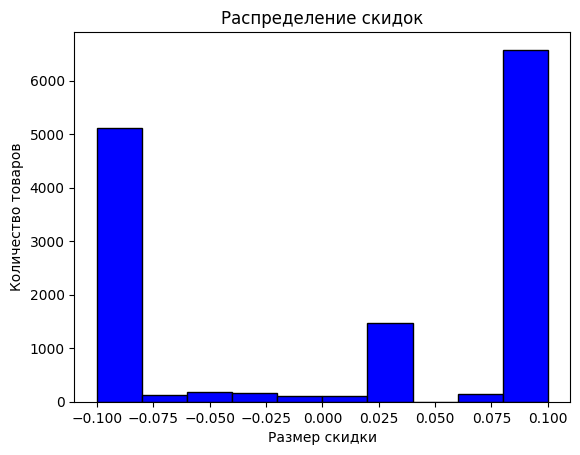

In [15]:
plot_distribution(df=optimal_df)

In [16]:
# Подсчитываем аплифты при выбранных скидках
calculate_uplifts(
    control_metrics=control_metrics,
    optimal_df=optimal_df,
)

Control margin: 971988058 руб.
Test margin: 1400872445 руб.
Uplift: 44 %
Control revenue: 3835279191 руб.
Test revenue: 5341882531 руб.
Uplift: 39 %


In [17]:
optimal_df[["sku_id", "ds", "price"]].round(2).to_csv(
    "./fp_solution/solution.csv", index=False
)

# Клиент

In [18]:
import logging
from typing import Any, Dict

import requests

logging.basicConfig()
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)


def create_session(base_url: str, user_id: int) -> int:
    url = f"{base_url}/sessions"
    headers = {"X-User-Id": str(user_id)}
    response = requests.post(url, headers=headers)
    if response.status_code == 201:
        return response.json()["id"]
    else:
        raise ValueError(
            f"Status code = {response.status_code}, Error: {response.text}"
        )


def get_daily_pricing_batch(
    base_url: str, session_id: int, user_id: int
) -> Dict[str, Any]:
    url = f"{base_url}/daily_pricing_batch"
    headers = {"X-Session-Id": str(session_id), "X-User-Id": str(user_id)}
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        return response.json()
    else:
        raise ValueError(
            f"Status code = {response.status_code}, Error: {response.text}"
        )


def upload_prices(
    base_url: str, session_id: int, user_id: int, prices_data: Dict[str, Any]
) -> None:
    url = f"{base_url}/prices"
    headers = {
        "X-Session-Id": str(session_id),
        "X-User-Id": str(user_id),
        "Content-Type": "application/json",
    }
    response = requests.post(url, headers=headers, json=prices_data)
    if response.status_code == 201:
        logger.info("Prices uploaded successfully")
    else:
        raise ValueError(
            f"Status code = {response.status_code}, Error: {response.text}"
        )


def get_results(
    base_url: str, ds: str, session_id: int, user_id: int
) -> Dict[str, Any]:
    url = f"{base_url}/results"
    headers = {"X-Session-Id": str(session_id), "X-User-Id": str(user_id)}
    params = {"ds": ds}
    response = requests.get(url, headers=headers, params=params)
    if response.status_code == 200:
        return response.json()
    else:
        raise ValueError(
            f"Status code = {response.status_code}, Error: {response.text}"
        )


def get_metrics(base_url: str, session_id: int, user_id: int) -> Dict[str, Any]:
    url = f"{base_url}/metrics"
    headers = {"X-Session-Id": str(session_id), "X-User-Id": str(user_id)}
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        return response.json()
    else:
        raise ValueError(
            f"Status code = {response.status_code}, Error: {response.text}"
        )

In [19]:
solution_df = pd.read_csv("./fp_solution/solution.csv")
solution_df = solution_df.rename(columns={"sku_id": "sku_ids", "price": "prices"})
solution_df["ds"] = pd.to_datetime(solution_df["ds"], format="%Y%m%d")
solution_df["ds"] = solution_df["ds"].dt.strftime("%Y-%m-%d")

print(solution_df.shape)
solution_df.head()

(14000, 3)


,sku_ids,ds,prices
0,499,2024-01-14,3949.83
1,541,2024-01-08,4113.21
2,541,2024-01-07,4113.21
3,541,2024-01-06,4113.21
4,541,2024-01-05,4113.21


In [32]:
BASE_URL = "https://dynamic-pricing.lab.karpov.courses"
USER_ID = 123
SESSION_ID = create_session(base_url=BASE_URL, user_id=USER_ID)

iteration_num = 0
results_dfs = []
while True:
    logger.info(
        f"Start {iteration_num} iteration, session_id = {SESSION_ID}, user_id = {USER_ID}"
    )
    daily_pricing_batch_dict = get_daily_pricing_batch(
        base_url=BASE_URL, session_id=SESSION_ID, user_id=USER_ID
    )
    ds = daily_pricing_batch_dict["ds"]
    logger.info(f"Processing ds = {ds}")
    daily_pricing_batch_df = pd.DataFrame(daily_pricing_batch_dict)

    prices_data_df = daily_pricing_batch_df.merge(
        solution_df, on=["sku_ids", "ds"], how="inner"
    )
    prices_data_df = prices_data_df[["sku_ids", "user_ids", "prices", "ds"]]
    prices_data_dict = prices_data_df.to_dict(orient="list")
    prices_data_dict["ds"] = ds

    upload_prices(
        base_url=BASE_URL,
        session_id=SESSION_ID,
        user_id=USER_ID,
        prices_data=prices_data_dict,
    )

    results_batch_dict = get_results(
        base_url=BASE_URL, ds=ds, session_id=SESSION_ID, user_id=USER_ID
    )
    results_batch_df = pd.DataFrame(results_batch_dict)
    results_dfs.append(results_batch_df)
    iteration_num += 1

INFO:__main__:Start 0 iteration, session_id = 1777810103576039424, user_id = 123
INFO:__main__:Processing ds = 2024-01-01
INFO:__main__:Prices uploaded successfully
INFO:__main__:Start 1 iteration, session_id = 1777810103576039424, user_id = 123
INFO:__main__:Processing ds = 2024-01-02
INFO:__main__:Prices uploaded successfully
INFO:__main__:Start 2 iteration, session_id = 1777810103576039424, user_id = 123
INFO:__main__:Processing ds = 2024-01-03
INFO:__main__:Prices uploaded successfully
INFO:__main__:Start 3 iteration, session_id = 1777810103576039424, user_id = 123
INFO:__main__:Processing ds = 2024-01-04
INFO:__main__:Prices uploaded successfully
INFO:__main__:Start 4 iteration, session_id = 1777810103576039424, user_id = 123
INFO:__main__:Processing ds = 2024-01-05
INFO:__main__:Prices uploaded successfully
INFO:__main__:Start 5 iteration, session_id = 1777810103576039424, user_id = 123
INFO:__main__:Processing ds = 2024-01-06
INFO:__main__:Prices uploaded successfully
INFO:__mai

ValueError: Status code = 400, Error: {"detail":"No more days to fill"}

In [33]:
metrics = get_metrics(base_url=BASE_URL, session_id=SESSION_ID, user_id=USER_ID)
results_df = pd.concat(results_dfs)

In [34]:
predicted_revenue = metrics["predicted"]["revenue"]
predicted_margin = metrics["predicted"]["margin"]

control_revenue = metrics["control"]["revenue"]
control_margin = metrics["control"]["margin"]

revenue_uplift = (predicted_revenue - control_revenue) / control_revenue * 100
margin_uplift = (predicted_margin - control_margin) / control_margin * 100

print(f"Ваша выручка: {round(predicted_revenue, 2)} руб.")
print(f"Контрольная выручка: {round(control_revenue, 2)} руб.")
print(f"Uplift по выручке: {round(revenue_uplift, 2)} %")

print(f"Ваша маржа: {round(predicted_margin, 2)} руб.")
print(f"Контрольная выручка: {round(control_margin, 2)} руб.")
print(f"Uplift по марже: {round(margin_uplift, 2)} %")

Ваша выручка: 210450365.24 руб.
Контрольная выручка: 191448583.03 руб.
Uplift по выручке: 9.93 %
Ваша маржа: 56644835.64 руб.
Контрольная выручка: 48404162.58 руб.
Uplift по марже: 17.02 %
